In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import h5py
from scipy import constants
from scipy.fft import rfft, rfftfreq
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

In [2]:
min_freq = 0.072 #GHz
max_freq = 0.108975 #GHz
channels = 1480
stations = 512
antenna_elements = 256
tot_antennas = stations * antenna_elements

frequencies = np.linspace(min_freq, max_freq, channels)*10**9 #Hz

In [3]:
def to_real_imag(gains):
    # Load incorrect real and imaginary components as amplitude and phase.
    amp, phase = gains.real, gains.imag

    # Convert to actual real and imaginary components, assuming phases are in degrees.
    real_imag = amp * np.exp(1j * phase)
    return complex(np.real(real_imag), np.imag(real_imag))

In [4]:
def w_complex(freq, cable_length, reflection_no, e_r=2.2, u_r=1):
    v_g = (2.998*10**8)/np.sqrt(e_r * u_r) # m/s
    optical_length = 2*reflection_no*cable_length
    delay =  float(optical_length / v_g) # seconds
    omega = 2*np.pi*delay
    return complex(0.95+np.sin(freq*omega)*0.05, (2*np.pi*freq/constants.c)*optical_length)

In [5]:
w_complex(0.108975*10**9, 10, 1)

(0.9010661108823994+45.6789422534369j)

In [6]:
def to_hdf5(gains, frequencies, station):    
    # Write HDF5 file with recognised dataset names.
    with h5py.File("antenna_gains_identical/gain_model_station_" + station + ".h5", "w") as hdf_file:
        hdf_file.create_dataset("freq (Hz)", data=frequencies)
        hdf_file.create_dataset("gain_xpol", data=gains)
        # hdf_file.create_dataset("gain_ypol", data=gains)

In [7]:
def get_gains(cable_length, freq, tolerence=False, hdf5=False):
    for station in range(512):
        if tolerence is True:
            length_tolerence = np.random.normal(0, 0.5*cable_length/100, antenna_elements)
        else:
            length_tolerence = np.zeros(antenna_elements)
        lengths = cable_length + length_tolerence 
        gains = []
        for l in lengths:
            single_antenna_gain = [] 
            for f in freq:   
                antenna_weights_amp_phase = w_complex(f, l, 1)
                antenna_weights_real_imag = to_real_imag(antenna_weights_amp_phase)
                single_antenna_gain.append(antenna_weights_real_imag)
            gains.append(single_antenna_gain)
        gains = np.array(gains, dtype=np.complex128).transpose()
        gains = gains.reshape(1, np.shape(gains)[0], np.shape(gains)[1])
        if hdf5 is True:
            to_hdf5(gains, freq, r(station))
    return gains

In [8]:
gains = get_gains(10, frequencies)

KeyboardInterrupt: 

In [ ]:
def calc_fft(min_freq, max_freq, channels, length):
    
    frequencies = np.linspace(min_freq, max_freq, channels) *10**9 #GHz
    duration = (frequencies[-1]-frequencies[0])/(channels-1) 
    
    gain_amp_phase = []
    gain_real_imag = []
    for f in frequencies:   
        antenna_weights = w_complex(f, length, 1)
        gain_amp_phase.append(antenna_weights)
        gain_real_imag.append(to_real_imag(antenna_weights))
        
        
    fig, ax = plt.subplots(2, figsize=(12, 8))
    
    ax[0].plot(frequencies, [i.real for i in gain_real_imag], label='Real', color='blue')
    ax[0].plot(frequencies, [i.imag for i in gain_real_imag], label='Imaginary', color='orange')

    xf = rfftfreq(channels, duration)
    yf_real = rfft([i.real for i in gain_real_imag])
    yf_imag = rfft([i.imag for i in gain_real_imag])
    
    ax[1].loglog(xf, np.abs(yf_real), label='Real', color='blue')
    ax[1].loglog(xf, np.abs(yf_imag), label='imag', color='orange')
    
    ax[0].set_title('Cable reflections: $S_{21}$ FFT', size='large')
    for a in ax:
        a.legend(loc=9, framealpha=1)
        
    ax[1].vlines(6.67*10**-8, ymax=10**10, ymin=0)
    ax[1].set_ylim([0, 5*10**5])
        
    ax[0].set_ylabel('Normalised Power', size='large')
    ax[1].set_ylabel('$PSD$', size='large')
    
    ax[1].set_xlabel('Frequency Domain: $\omega$ (rad $s^{-1}$)', size='large')
    ax[0].set_xlabel('Time Domain: Frequency (Hz)', size='large')
    plt.subplots_adjust(hspace=0.01)
    fig.tight_layout()
    plt.show()

In [ ]:
min_freq = 0.072 #GHz
max_freq = 0.108975*2 #GHz
channels = 1480*200

calc_fft(min_freq, max_freq, channels, 10)

In [54]:
length = 10
frequencies = np.linspace(min_freq, max_freq, channels) *10**9 #GHz
duration = (frequencies[-1]-frequencies[0])/(channels-1) 

gain_amp_phase = []
gain_real_imag = []
for f in frequencies:   
    antenna_weights = w_complex(f, length, 1)
    gain_amp_phase.append(antenna_weights)

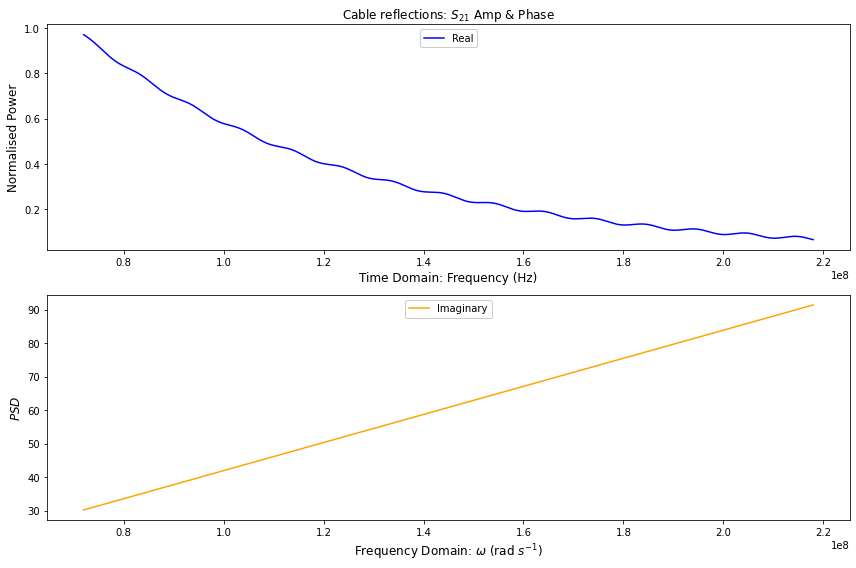

In [55]:
fig, ax = plt.subplots(2, figsize=(12, 8))

ax[0].plot(frequencies, [i.real for i in gain_amp_phase], label='Real', color='blue')
ax[1].plot(frequencies, [i.imag for i in gain_amp_phase], label='Imaginary', color='orange')

ax[0].set_title('Cable reflections: $S_{21}$ Amp & Phase', size='large')
for a in ax:
    a.legend(loc=9, framealpha=1)

ax[0].set_ylabel('Normalised Power', size='large')
ax[1].set_ylabel('$PSD$', size='large')

ax[1].set_xlabel('Frequency Domain: $\omega$ (rad $s^{-1}$)', size='large')
ax[0].set_xlabel('Time Domain: Frequency (Hz)', size='large')
plt.subplots_adjust(hspace=0.01)
fig.tight_layout()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (2960,) and (1480,)

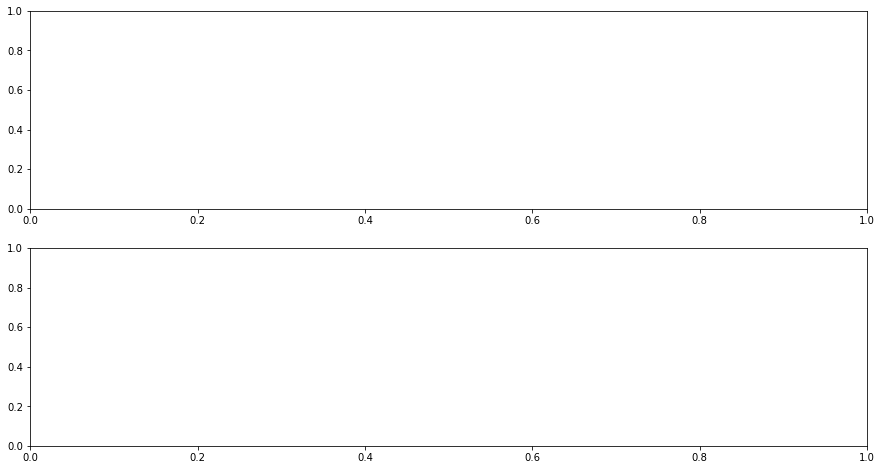

In [243]:
fig, ax = plt.subplots(2, figsize=(15, 8))
gains_real = [i[0].real for i in gains[0]] 
gains_imag = [i[0].imag for i in gains[0]]

ax[0].plot(frequencies, gains_real, label='Real')
ax[0].plot(frequencies, gains_imag, label='Imag')

ax[1].semilogy(xf, np.abs(yf_real))

ax[0].set_title('Cable reflections: $S_{21}$ FFT', size='xx-large')
ax[0].set_xlabel('Frequency (GHz)', size='xx-large')
for a in ax:
    a.legend(loc=9, framealpha=1)

ax[0].set_ylabel('$S_{21}$', size='xx-large')
ax[1].set_ylabel('$Power$', size='xx-large')
ax[1].vlines(50, 0, 5000)
plt.subplots_adjust(hspace=0.01)
fig.tight_layout()
plt.show()

array([    0.        ,    27.02702703,    54.05405405,    81.08108108,
         108.10810811,   135.13513514,   162.16216216,   189.18918919,
         216.21621622,   243.24324324,   270.27027027,   297.2972973 ,
         324.32432432,   351.35135135,   378.37837838,   405.40540541,
         432.43243243,   459.45945946,   486.48648649,   513.51351351,
         540.54054054,   567.56756757,   594.59459459,   621.62162162,
         648.64864865,   675.67567568,   702.7027027 ,   729.72972973,
         756.75675676,   783.78378378,   810.81081081,   837.83783784,
         864.86486486,   891.89189189,   918.91891892,   945.94594595,
         972.97297297,  1000.        ,  1027.02702703,  1054.05405405,
        1081.08108108,  1108.10810811,  1135.13513514,  1162.16216216,
        1189.18918919,  1216.21621622,  1243.24324324,  1270.27027027,
        1297.2972973 ,  1324.32432432,  1351.35135135,  1378.37837838,
        1405.40540541,  1432.43243243,  1459.45945946,  1486.48648649,
      

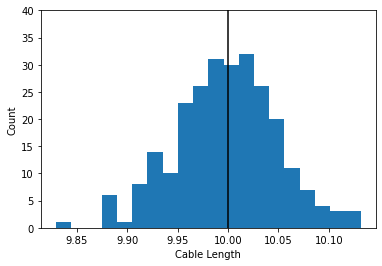

In [8]:
tolerences = np.random.normal(0, 0.5*10/100, antenna_elements) + 10 
plt.hist(tolerences, bins=20)
plt.vlines(10, 0, 80, color='k')
plt.ylim(0,40)
plt.xlabel('Cable Length')
plt.ylabel('Count')
plt.show()

In [3]:
s21_params = np.array([
    (0.917, 0.007428, 428, 7.866, 1.844, 1.503, 0.1759),
    (0.8922,-0.00734, 612.1, -7.827, 1.945, 1.281, 0.2909),
    (0.8738, 0.007201, 735.5, 1.605, 1.979, 1.175, 0.3455),
    (0.8922,-0.00734, 6121, -7.827, 1.945, 1.281, 0.2909)
]) # format: (y_0, A, omega, phi, alpha, x_0, beta)

lengths = (7, 10, 12)
stations = 512
antenna_elements = 256
tot_antennas = stations * antenna_elements

In [62]:
def S_21(freq, y_0, A, omega, phi, alpha, x_0, beta):
    return  A*np.sin(omega*freq + phi)*np.exp(-beta*freq) #+ y_0 + np.exp(-alpha*(freq+x_0))

In [63]:
min = 0.072 #GHz
max = 0.108975 #GHz
channels = 1480
frequencies = np.linspace(min, max, channels)

In [64]:
# Initalise variables for 7m Coax Cable 
results_7m = S_21(frequencies, *s21_params[0])
results_10m = S_21(frequencies, *s21_params[1])
results_12m = S_21(frequencies, *s21_params[2])
results_omega = S_21(frequencies, *s21_params[3])

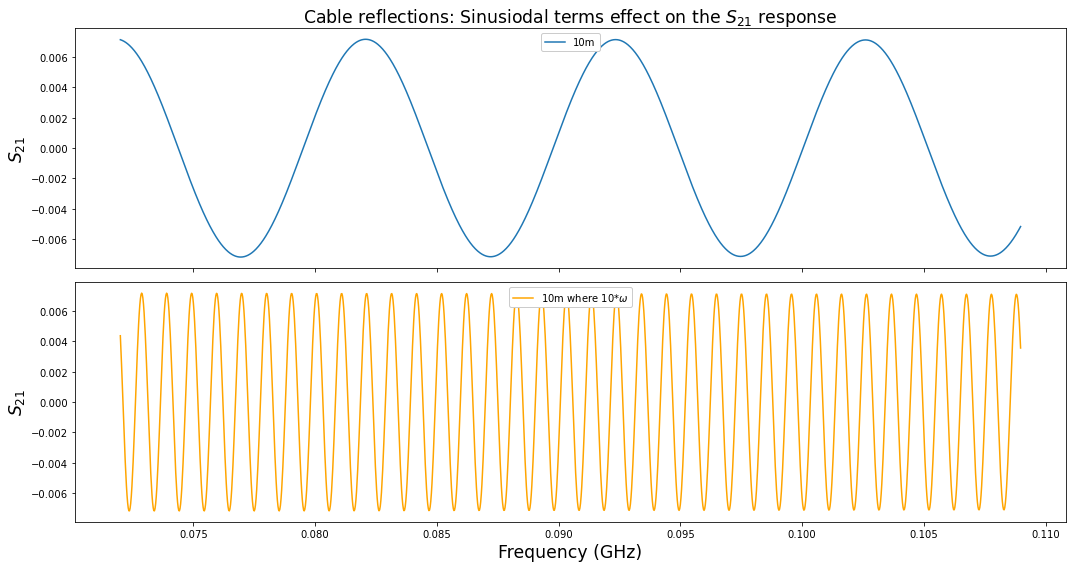

In [93]:
fig, ax = plt.subplots(2, sharex=True, figsize=(15, 8))
ax[1].plot(frequencies, results_omega, label='10m where 10*$\omega$', color='orange')
ax[0].plot(frequencies, results_10m, label='10m')
#ax.plot(frequencies, results_12m, label='12m')

ax[0].set_title('Cable reflections: Sinusiodal terms effect on the $S_{21}$ response', size='xx-large')
ax[1].set_xlabel('Frequency (GHz)', size='xx-large')
for a in ax:
    a.legend(loc=9, framealpha=1)
    a.set_ylabel('$S_{21}$', size='xx-large')
plt.subplots_adjust(hspace=0.01)
fig.tight_layout()
plt.show()

In [20]:
def S_21_2nd(freq):
    return y_0 + A*(np.sin(omega_2*freq + phi)+np.sin(omega*freq + phi))*np.exp(-beta*freq)+np.exp(-alpha*(freq+x_0))

In [10]:
# Initalise variables for 10m Coax Cable 
omega_2 = 3*omega/5

results_2nd = S_21_2nd(frequencies)

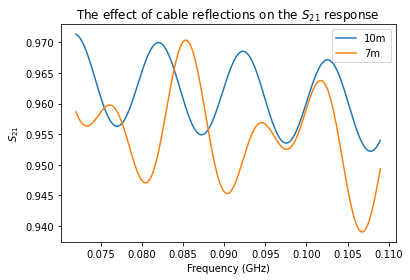

In [11]:
plt.plot(frequencies, results_10m, label='10m')
plt.plot(frequencies, results_2nd, label='7m')
plt.title('The effect of cable reflections on the $S_{21}$ response')
plt.ylabel('$S_{21}$')
plt.xlabel('Frequency (GHz)')
plt.legend()
plt.show()

In [64]:
# Save Data to .txt
data = np.column_stack([frequencies, results_2nd])
datafile_path = "10m_S21_parameter_2nd.txt"
np.savetxt(datafile_path , data, fmt=['%f','%f'])
# here the ascii file is written. 